In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
batch_size = 32
learning_rate = 0.001
training_steps = 5000
eval_frequency = 100
random_seed = 42

Nz = 50
Nx = 10

In [3]:
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds

from model.vae import VAEOutput, VariationalAutoEncoder
from model.loss import binary_cross_entropy,kl_gaussian, loss_fn, loss_fn2
from model.encoder import Encoder
from model.decoder import Decoder

In [4]:
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]

MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)


def load_dataset(split: str, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))

2023-11-12 23:52:16.399324: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


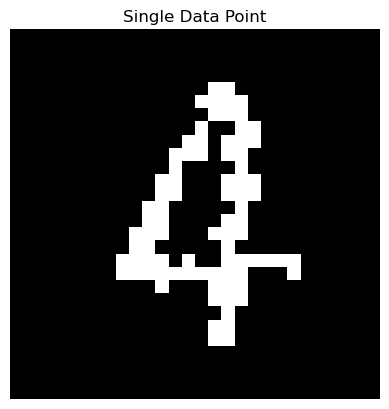

In [5]:
batch_size = 32
train_ds = load_dataset(tfds.Split.TRAIN, batch_size)
valid_ds = load_dataset(tfds.Split.TEST, batch_size)

# Get a single batch from the training dataset
batch = next(train_ds)

# Take the first data point from the batch
data_point = batch['image'][0]
import matplotlib.pyplot as plt

plt.imshow(data_point.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point')
plt.axis('off')
plt.show()

In [6]:
model = hk.transform(lambda x: VariationalAutoEncoder()(x))  
optimizer = optax.adam(learning_rate)

In [7]:
@jax.jit
def loss_fn(params: hk.Params, rng_key,batch) -> jnp.ndarray:
  """ELBO: E_p[log(x)] - KL(d||q), where p ~ Be(0.5) and q ~ N(0,1)."""
  outputs: VAEOutput = model.apply(params, rng_key, batch["image"])
  print("batch imgL",batch["image"])
  log_likelihood = -binary_cross_entropy(batch["image"], outputs.logits)
  kl = kl_gaussian(outputs.mean, jnp.square(outputs.stddev))
  elbo = log_likelihood - kl

  return -jnp.mean(elbo)

def loss_fn2(params: hk.Params, rng_key,batch) -> jnp.ndarray:
  outputs: VAEOutput = model.apply(params, rng_key, batch["image"])
  log_likelihood = -binary_cross_entropy(batch["image"], outputs.logits)
  kl = kl_gaussian(outputs.mean, jnp.square(outputs.stddev))
  elbo = log_likelihood - kl

  return jnp.mean(log_likelihood), jnp.mean(kl)

@jax.jit
def update(
    params: hk.Params,
    rng_key: PRNGKey,
    opt_state: optax.OptState,
    batch: Batch, ) -> Tuple[hk.Params, optax.OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

2023-11-12 23:52:20.096678: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


batch imgL Traced<ShapedArray(uint8[32,28,28,1])>with<DynamicJaxprTrace(level=4/0)>
STEP: 0 ELBO: -522.9515 recon_loss: -520.0499 kl: 1.1134039


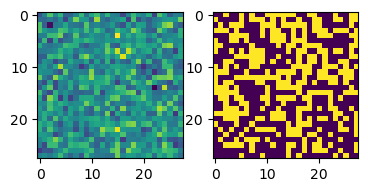

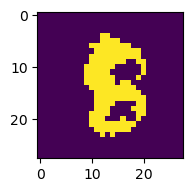

STEP: 250 ELBO: -152.86751 recon_loss: -129.67816 kl: 14.607269


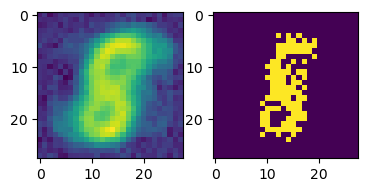

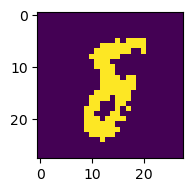

STEP: 500 ELBO: -130.69722 recon_loss: -114.45827 kl: 14.731571


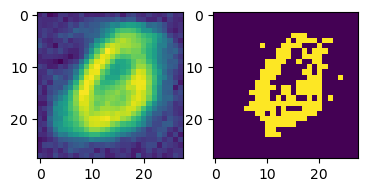

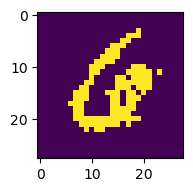

STEP: 750 ELBO: -132.16446 recon_loss: -112.36237 kl: 16.2332


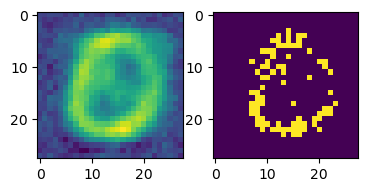

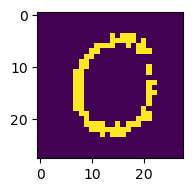

STEP: 1000 ELBO: -121.00182 recon_loss: -118.052956 kl: 17.314045


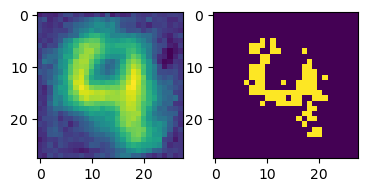

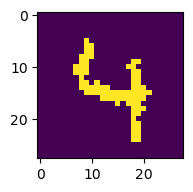

STEP: 1250 ELBO: -118.53637 recon_loss: -110.69328 kl: 16.620773


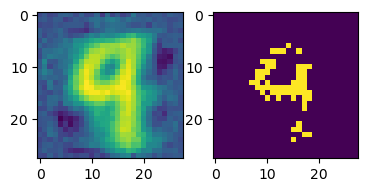

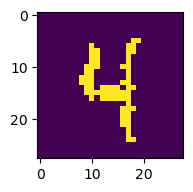

STEP: 1500 ELBO: -124.90009 recon_loss: -99.55775 kl: 16.77771


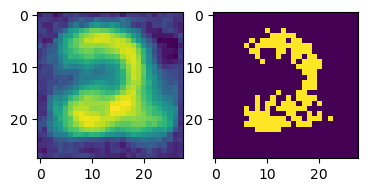

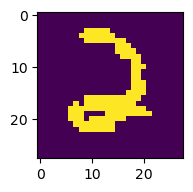

batch imgL Traced<ShapedArray(uint8[16,28,28,1])>with<DynamicJaxprTrace(level=4/0)>
STEP: 1750 ELBO: -122.20173 recon_loss: -96.979324 kl: 16.896854


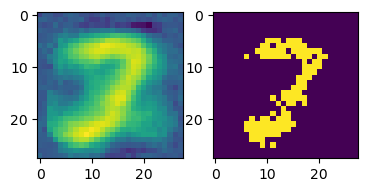

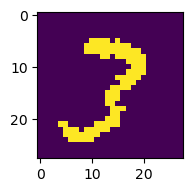

STEP: 2000 ELBO: -115.17192 recon_loss: -97.97746 kl: 16.530012


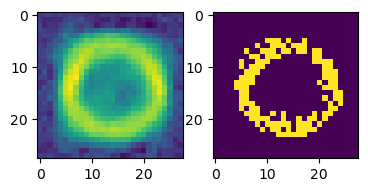

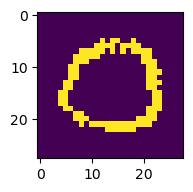

STEP: 2250 ELBO: -112.01156 recon_loss: -98.32386 kl: 17.897507


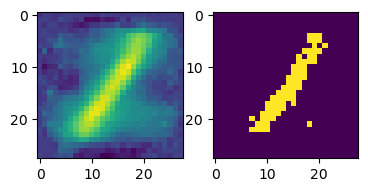

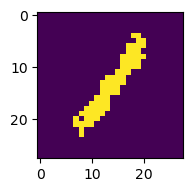

STEP: 2500 ELBO: -112.38596 recon_loss: -100.621704 kl: 17.942268


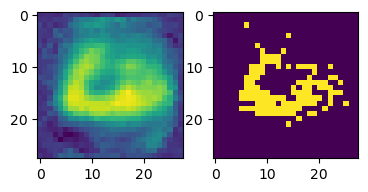

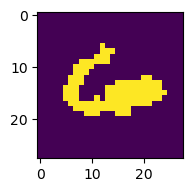

STEP: 2750 ELBO: -118.720375 recon_loss: -88.16086 kl: 17.522614


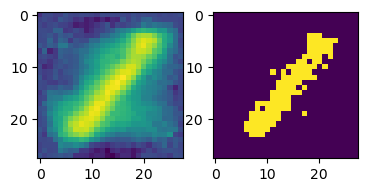

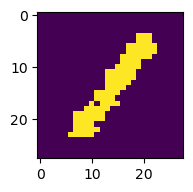

STEP: 3000 ELBO: -107.52357 recon_loss: -103.61352 kl: 17.810143


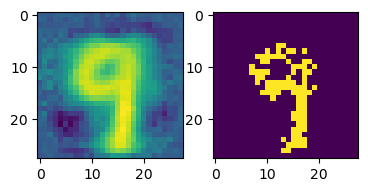

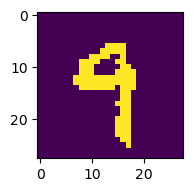

STEP: 3250 ELBO: -115.17502 recon_loss: -95.41986 kl: 17.903986


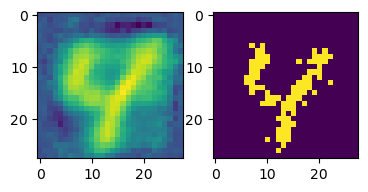

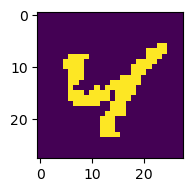

STEP: 3500 ELBO: -115.30362 recon_loss: -100.07422 kl: 17.401047


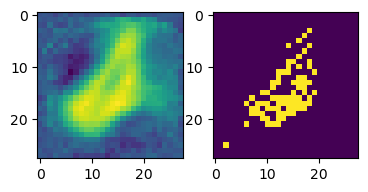

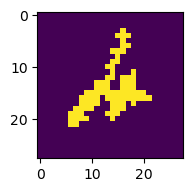

STEP: 3750 ELBO: -110.52426 recon_loss: -90.222435 kl: 16.810982


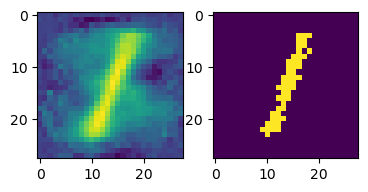

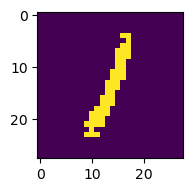

STEP: 4000 ELBO: -116.97342 recon_loss: -86.86432 kl: 17.658325


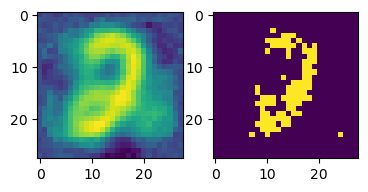

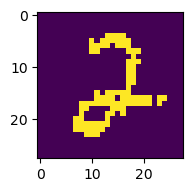

STEP: 4250 ELBO: -114.3697 recon_loss: -87.14014 kl: 17.560188


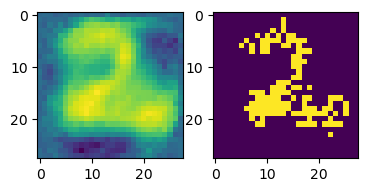

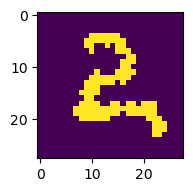

STEP: 4500 ELBO: -122.34485 recon_loss: -87.45744 kl: 18.248077


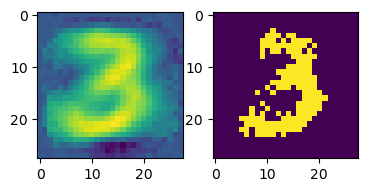

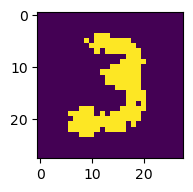

STEP: 4750 ELBO: -111.26843 recon_loss: -100.111084 kl: 18.605185


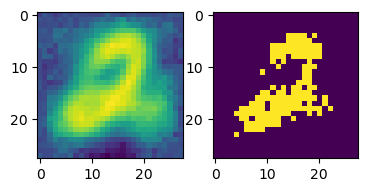

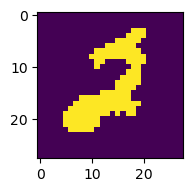

In [8]:
rng_seq = hk.PRNGSequence(random_seed)
params = model.init(next(rng_seq), np.zeros((1, *MNIST_IMAGE_SHAPE)))
opt_state = optimizer.init(params)

train_ds = load_dataset(tfds.Split.TRAIN, batch_size)
valid_ds = load_dataset(tfds.Split.TEST, batch_size)

elbo_values = []
recon_loss_values = []
kl_values = []


for step in range(training_steps):
  params, opt_state = update(
      params,
      next(rng_seq),
      opt_state,
      next(train_ds),
      )
  if step % 250 == 0:
    val_loss = loss_fn(params, next(rng_seq), next(valid_ds))
    recon_loss, kl = loss_fn2(params, next(rng_seq), next(valid_ds))

    elbo_values.append(val_loss)
    recon_loss_values.append(-recon_loss)
    kl_values.append(kl)
    print("STEP:", step, "ELBO:", -val_loss, "recon_loss:",recon_loss, "kl:", kl)
    a = next(valid_ds)['image']
    outputs: VAEOutput = model.apply(params, next(rng_seq),a)
      
    plt.subplot(1, 3, 1)
    plt.imshow(outputs.logits[0].squeeze())
    plt.subplot(1, 3, 2)
    plt.imshow(outputs.image[0].squeeze())
    plt.show()
    plt.subplot(1, 3, 3)
    plt.imshow(a[0].squeeze())
    plt.show()

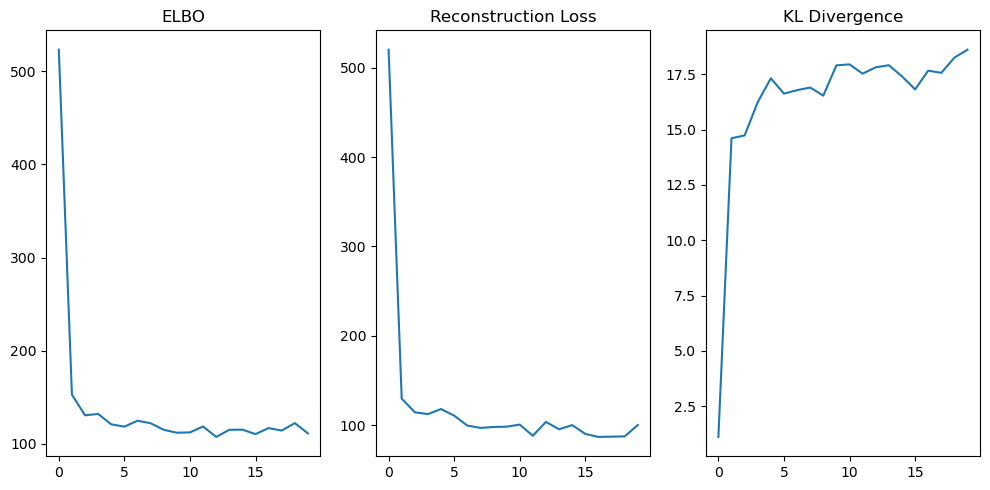

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.plot(elbo_values)
plt.title('ELBO')

plt.subplot(1, 3, 2)
plt.plot(recon_loss_values)
plt.title('Reconstruction Loss')

plt.subplot(1, 3, 3)
plt.plot(kl_values)
plt.title('KL Divergence')

plt.tight_layout()
plt.show()

In [10]:
trained_params = params
encoder_params = {k: v for k, v in trained_params.items() if '/encoder/' in k}
decoder_params = {k: v for k, v in trained_params.items() if 'decoder' in k}
new_encoder_params = {key.replace('variational_auto_encoder/', ''): value for key, value in encoder_params.items()}
new_decoder_params = {key.replace('variational_auto_encoder/', ''): value for key, value in decoder_params.items()}

In [11]:
from acquiring.sample_image import sample_a_image, get_next,update_images

In [15]:
sample_a_image_fn = jax.vmap(sample_a_image, in_axes=(None, None, 0, 0, None, None, 0))
get_next_fn = jax.vmap(get_next)
update_images_fn = jax.vmap(update_images)

In [17]:
#Perform acquiring over a batch of dataset:
orginial_images = batch['image']

images_float = orginial_images.astype(np.float32)
half_height = images_float.shape[1] // 2

images_with_top_half_missing = images_float.copy()
images_with_top_half_missing[:, :half_height, :, :] = np.nan
#Get mask
mask_missing = np.isnan(images_with_top_half_missing)
mask_observed = ~mask_missing

images_refill = update_images_fn(orginial_images,mask_observed)

In [18]:
rng_seq = hk.PRNGSequence(random_seed)
rng_miss = next(rng_seq)
encoder = hk.transform(lambda x: Encoder(512,10)(x))
mean, log_var = encoder.apply(new_encoder_params, rng_miss, images_refill)
decoder = hk.transform(lambda x: Decoder(512, MNIST_IMAGE_SHAPE)(x))
new_outputs: VAEOutput = model.apply(trained_params, rng_miss, images_refill)
log_likelihood = -binary_cross_entropy(batch["image"], jax.nn.sigmoid(new_outputs.logits))
init_loss = jnp.mean(log_likelihood)
init_loss

Array(-536.70215, dtype=float32)

In [19]:
def update(images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    batch_rng = jax.random.split(rng, batch_size) 
    mean, log_var = encoder.apply(new_encoder_params, rng_miss, images)
    R = sample_a_image_fn(Nz, Nx, mean, log_var, decoder, new_decoder_params, batch_rng)
    images_updated, mask_return = get_next_fn(R, mask_observed, images,orginial_images)
    return images_updated, mask_return

Step 0: Mean Log Likelihood = -522.5457763671875


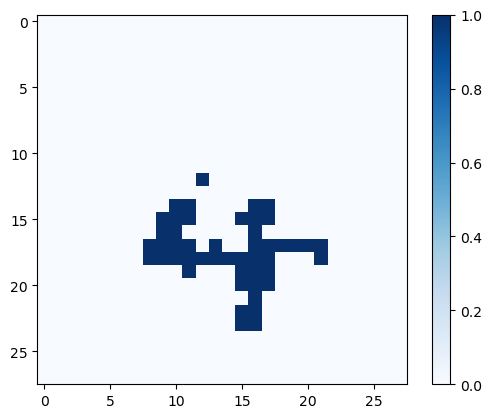

Step 50: Mean Log Likelihood = -511.2322998046875


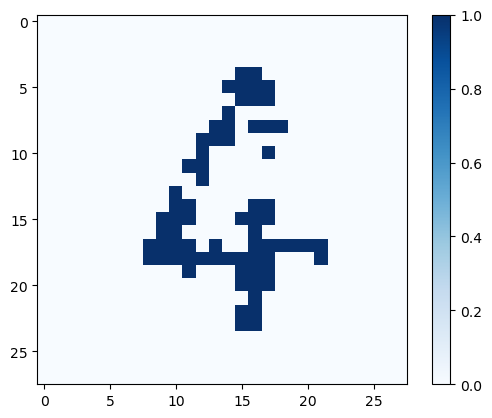

Step 100: Mean Log Likelihood = -506.02069091796875


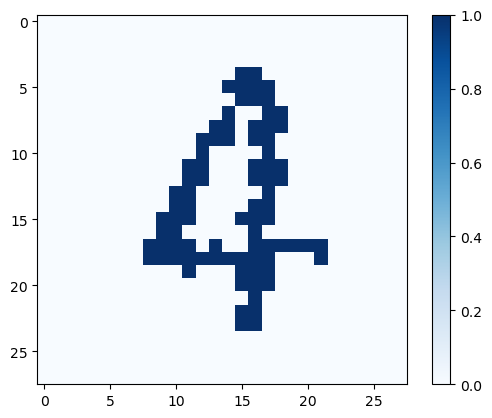

Step 150: Mean Log Likelihood = -504.88104248046875


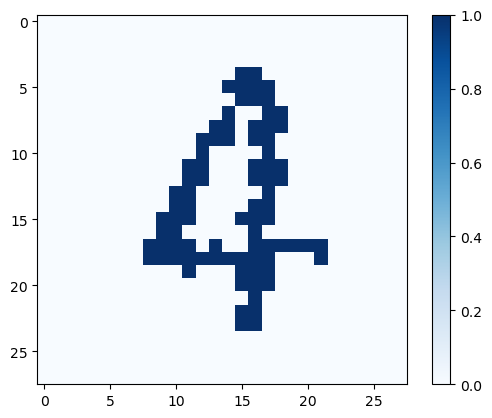

Step 200: Mean Log Likelihood = -504.67926025390625


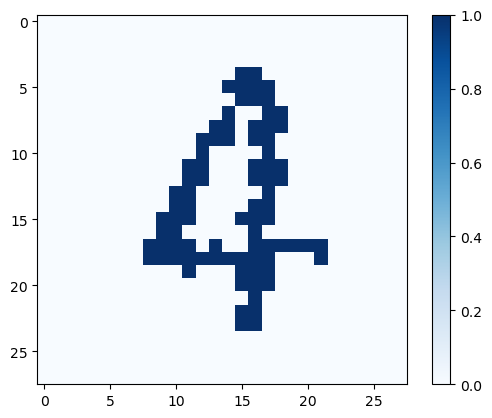

Step 250: Mean Log Likelihood = -504.67926025390625


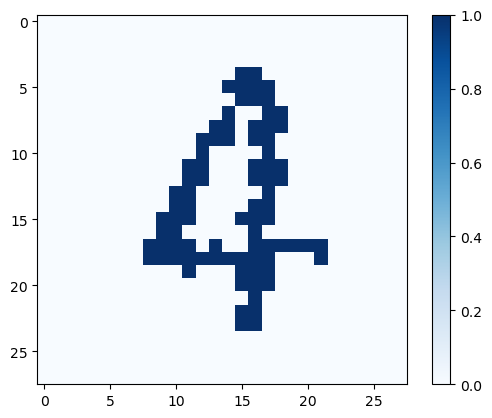

Step 300: Mean Log Likelihood = -504.67926025390625


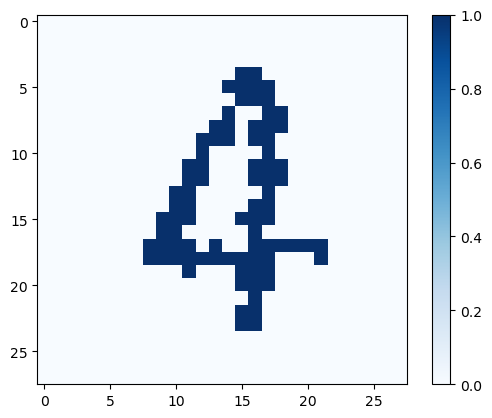

Step 350: Mean Log Likelihood = -504.67926025390625


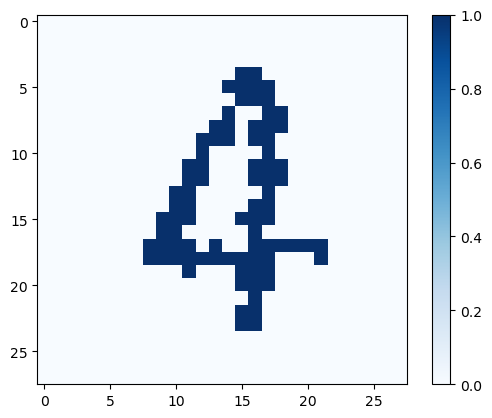

Step 400: Mean Log Likelihood = -504.67926025390625


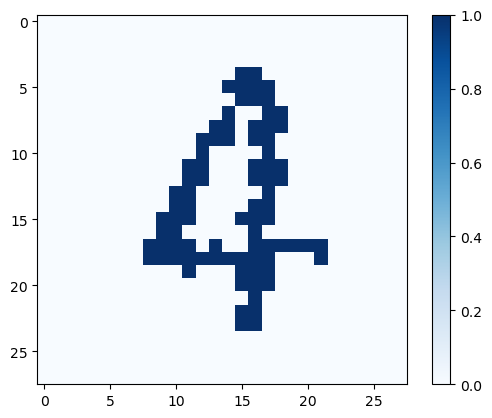

Step 450: Mean Log Likelihood = -504.67926025390625


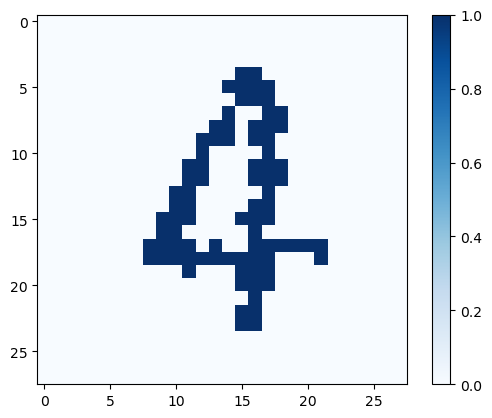

In [69]:
inital_images = images_refill
initial_mask = mask_observed
current_images = inital_images
current_mask = initial_mask

steps = 50  # Calculate log likelihood every 100 steps
step_counter = 0
max_step = 500
recon_value = []

while np.any(~mask_observed) and step_counter< max_step:
    current_images, current_mask = update(current_images, current_mask, rng_miss)
    
    if step_counter % steps == 0:
        new_log_likelihood = -binary_cross_entropy(batch["image"], current_images)
        mean_log_likelihood = jnp.mean(new_log_likelihood)
        recon_value.append(-mean_log_likelihood)
        print(f"Step {step_counter}: Mean Log Likelihood = {mean_log_likelihood}")
        plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
        plt.colorbar()
        plt.show()
        
    step_counter += 1
    


Text(0.5, 1.0, 'Reconstruction By Acquiring')

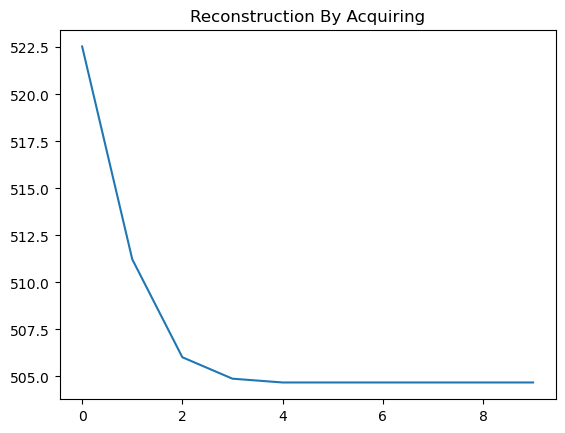

In [70]:
plt.plot(recon_value)
plt.title('Reconstruction By Acquiring')

In [71]:
from acquiring.sample_image import random_get_next
from jax import random

In [72]:
def random_update(images: jnp.ndarray, mask_observed: jnp.ndarray, rng):
    images_updated, mask_return = random_get_next(mask_observed, images, orginial_images, rng)
    return images_updated, mask_return

Step 0: Mean Log Likelihood = -522.8306884765625


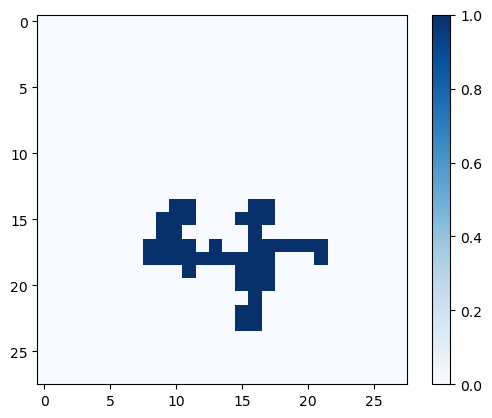

Step 50: Mean Log Likelihood = -520.9550170898438


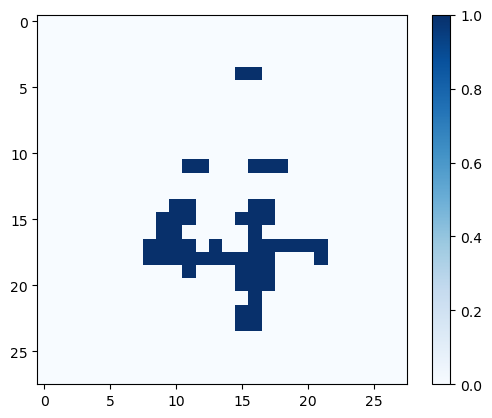

Step 100: Mean Log Likelihood = -519.1505126953125


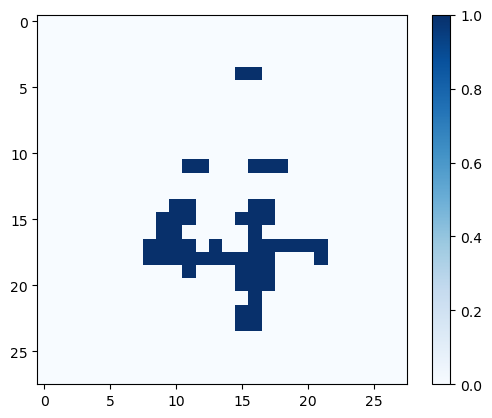

Step 150: Mean Log Likelihood = -517.3460693359375


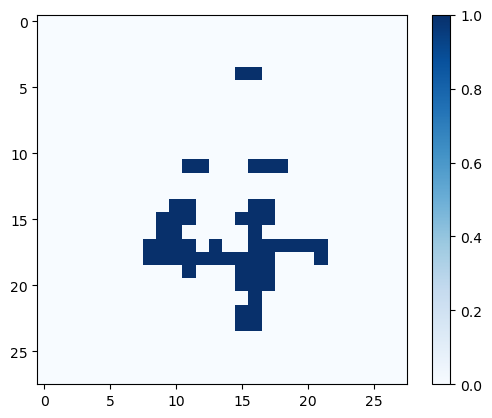

Step 200: Mean Log Likelihood = -514.6275024414062


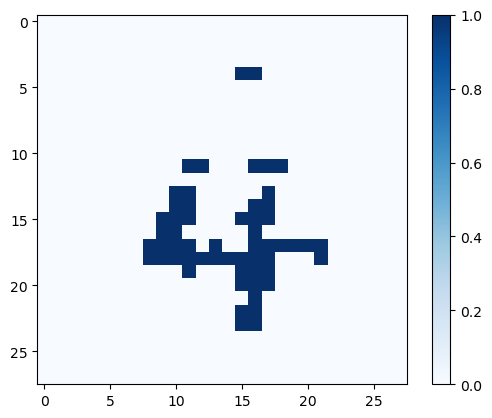

Step 250: Mean Log Likelihood = -512.5025634765625


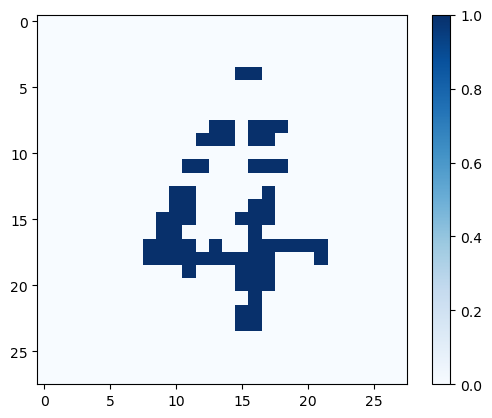

Step 300: Mean Log Likelihood = -510.36566162109375


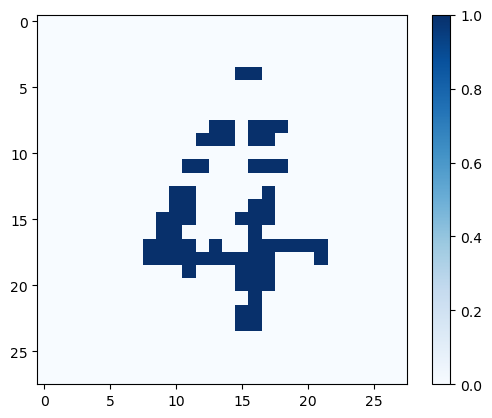

Step 350: Mean Log Likelihood = -508.5849609375


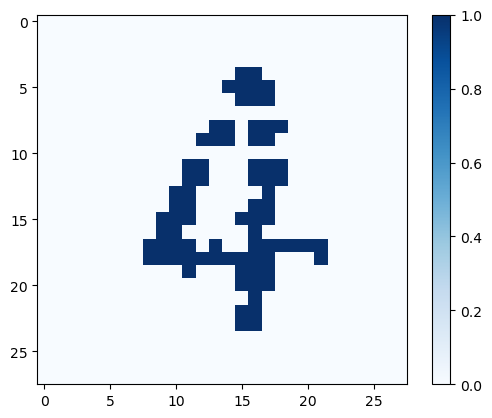

Step 400: Mean Log Likelihood = -506.2581481933594


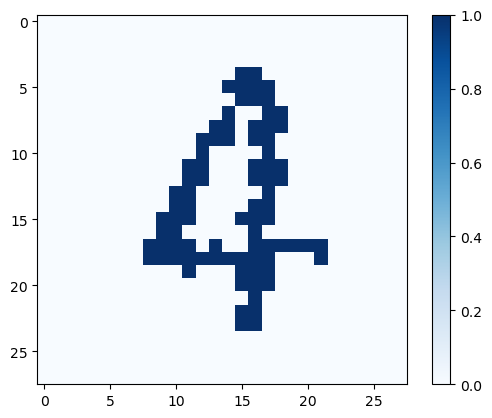

Step 450: Mean Log Likelihood = -504.48931884765625


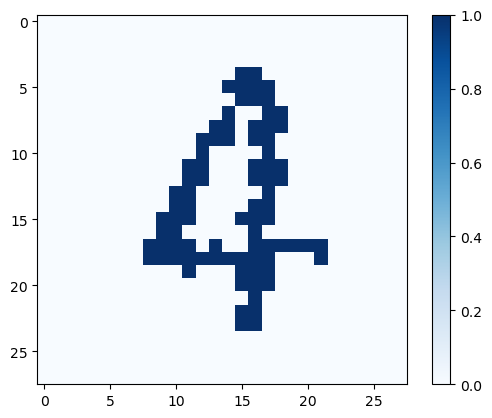

In [73]:
inital_images = images_refill
initial_mask = mask_observed
current_images = inital_images
current_mask = initial_mask

steps = 50  # Calculate log likelihood every 100 steps
step_counter = 0
max_step = 500
random_recon = []

while np.any(~mask_observed) and step_counter< max_step:
    current_images, current_mask = random_update(current_images, current_mask, rng_miss)
    
    if step_counter % steps == 0:
        new_log_likelihood = -binary_cross_entropy(batch["image"], current_images)
        mean_log_likelihood = jnp.mean(new_log_likelihood)
        random_recon.append(-mean_log_likelihood)
        print(f"Step {step_counter}: Mean Log Likelihood = {mean_log_likelihood}")
        plt.imshow(current_images[0], cmap='Blues', vmin=0, vmax=1)
        plt.colorbar()
        plt.show()
        
    step_counter += 1

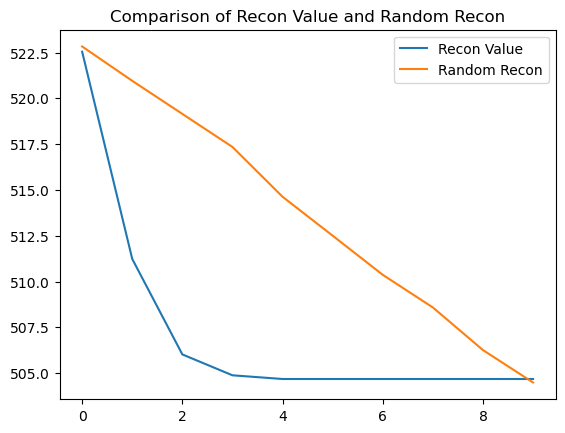

In [74]:

# Assuming recon_value and random_recon are your data lists or arrays
plt.plot(recon_value, label='Recon Value')
plt.plot(random_recon, label='Random Recon')

plt.title('Comparison of Recon Value and Random Recon')
plt.legend()

plt.show()
